In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
import matplotlib
import seaborn as sns
import sys
import os
from os import path
import yaml
import copy
from scipy import stats
from statsmodels.stats.contingency_tables import Table2x2
from importlib import reload
import pickle
import PIL

In [8]:
os.chdir('../..')
from mega_analysis.crosstab.mega_analysis.MEGA_ANALYSIS import MEGA_ANALYSIS
from mega_analysis import Sankey_Functions
from mega_analysis.crosstab.mega_analysis.QUERY_SEMIOLOGY import QUERY_SEMIOLOGY
from mega_analysis.crosstab.NORMALISE_TO_LOCALISING_VALUES import NORMALISE_TO_LOCALISING_VALUES
from mega_analysis.crosstab.file_paths import file_paths
from mega_analysis.crosstab.lobe_top_level_hierarchy_only import top_level_lobes
from mega_analysis.crosstab.hierarchy_dictionaries import temporal_postcodes
from mega_analysis.semiology import recursive_items

In [9]:
from scripts.figures import interogate_queries, labels
from scripts.figures  import plotter

# Define lists & file paths

In [10]:
repo_dir, resources_dir, excel_path, semiology_dict_path = file_paths()

Semio2Brain_Database = r'/Volumes/Encrypted/Semiology-Visualisation-Tool/resources/__Semio2Brain Database v1.1.0.xlsx'

with open(semiology_dict_path) as f:
    SemioDict = yaml.load(f, Loader=yaml.FullLoader)

In [11]:
region_names = labels.get_region_names()

In [12]:
semiology_list = list(recursive_items(SemioDict))

# Get df from Excel sheet & query df

If previously run notebook, get pickled results of MEGA_ANALYSIS, QUERY_SEMIOLOGY, normalisatione etc, and then go straight to Get sorted list of semiologies

In [13]:
with open('scripts/figures/query_results_pickle.pkl', 'rb') as f:
    query_results = pickle.load(f)
    
with open('scripts/figures/all_dfs_pickle.pkl', 'rb') as f:
    all_dfs = pickle.load(f)

If no pickle available, run:

In [592]:
(original_df, 
df_ground_truth, df_study_type,
num_database_articles, num_database_patients, num_database_lat, num_database_loc) = \
                MEGA_ANALYSIS(Semio2Brain_Database)
print(original_df.shape)

(2577, 121)


In [593]:
def query_semiology_wrapper(df, semiology_list, semiology_dict_path):
    query_results = {}
    for semiology in semiology_list:
        query_inspection, num_query_lat, num_query_loc = QUERY_SEMIOLOGY(df,
                                                                     semiology_term=semiology,
                                                                     ignore_case=True,
                                                                     semiology_dict_path=semiology_dict_path,
                                                                     all_columns_wanted = True)
                                                                             # col1=col1, col2=col1)
            
        one_query_result = {
            'query_inspection': query_inspection,
            'num_query_lat': num_query_lat,
            'num_query_loc': num_query_loc
        }
        query_results[semiology] = one_query_result
    return query_results

In [594]:
df = copy.deepcopy(original_df)
all_dfs = {
    'full': df,
    'spontaneous': df[df['Spontaneous Semiology (SS)'] == 'y'],
    'topology':  df[df['Spontaneous Semiology (SS)'] != 'y'],
}

In [596]:
query_results = {}
for key, df in all_dfs.items():
    query_results[key] = query_semiology_wrapper(df, semiology_list, semiology_dict_path)

# Get sorted list of semiologies

In [597]:
def sort_semiologies_by_n(query_result, top_n = 0, include_n = False):
    """
    Get semiologies in order of most frequently seen, based on query results
    
    Input:
    - query_results: a dictionary where keys are semiologies and values are
    'query_inspection' for that semiology, as returned by QUERY_SEMIOLOGY
    (often query_results['not_normalised']['full'])
    - top_n can be used to get the n semiologies with the highest number of cases
    - include_n = True to return the frequency of each semiology
    """
    n_results = []
    for k, v in query_result.items():
        n_results.append(v['num_query_loc'])
    n_results = np.array(n_results)
    
    labels = list(query_result.keys())
    sorted_result = np.sort(n_results)
    sorted_index = np.argsort(n_results)
    sorted_labels = [labels[i] for i in sorted_index]
    if include_n:
        return tuple(zip(sorted_labels[-top_n:], sorted_result[-top_n:]))
    else:
        return sorted_labels[-top_n:]

In [598]:
sorted_semiologies = sort_semiologies_by_n(query_results['full'])

---
# Figure 1 - P (Localisation | Semiology)
---

In [599]:
plt.rc('font', size=8)          # controls default text sizes
plt.rc('axes', titlesize=9)     # fontsize of the axes title
plt.rc('axes', labelsize=9)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=7)    # fontsize of the tick labels
plt.rc('ytick', labelsize=7)    # fontsize of the tick labels
plt.rc('legend', fontsize=7)    # legend fontsize
plt.rc('figure', titlesize=10) 

In [600]:
legend_labels = ['ALl studies', 'Spontaneous Semiology only']
# colors = ['#009988', '#cc3311'] # green, red
colors = [sns.color_palette("Greys")[3], sns.color_palette()[0]] # greys
# colors =  [(0.5085736255286428, 0.5085736255286428, 0.5085736255286428, 0.5), matplotlib.colors.colorConverter.to_rgba('black', alpha=.5)] #greys, transparent
# colors = [sns.color_palette("Greens")[3], sns.color_palette("Greens")[5]] # greens
# colors = [sns.color_palette("Greys")[4], sns.color_palette("Greens")[5]] # grey-greens
plotter_settings = {
    'ls': 'none',
    'linewidth': 1,
    'marker': 'o',
    'markeredgewidth': 1,
    'markersize': 3.5,
#     'markerfacecolor': 'white',
#     'alpha': 0.5
}

In [618]:
results = {}
for study_type, query_result in query_results.items():
    result = interogate_queries.summarise_query(
        query_result,
        axis = 'semiology',
        region_names = region_names,
        normalise = False,
        merge_temporal = False,
        semiologies_of_interest = sorted_semiologies[-12:],
        drop_other_semiology = True,
        merge_other_regions = True,
        drop_other_regions = False,
        confint_method = 'bootstrap',
        bootstrapping_samples = 10000)
    
    results[study_type] = result

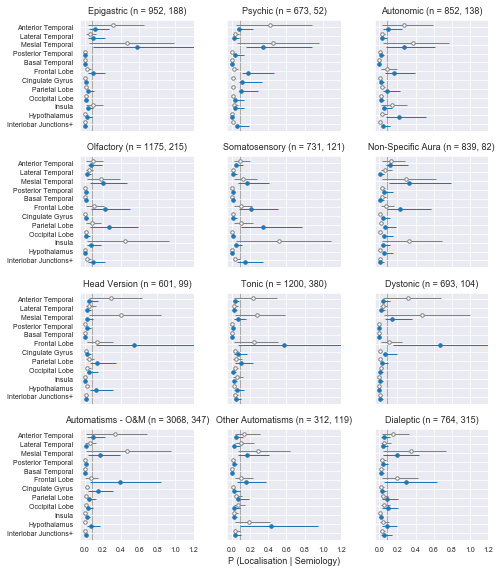

In [619]:
sns.set_style('darkgrid')
fig, axs = plotter.plot_proportion_ci_forest_plot(
                               proportion_df_1 = results['full']['proportion'],
                               confint_df_1 = results['full']['confints'],
                               counts_df_1 = results['full']['counts'],
                               colors = colors,
                               legend_labels = legend_labels,
                               proportion_df_2 = results['spontaneous']['proportion'],
                               confint_df_2 = results['spontaneous']['confints'],
                               counts_df_2 = results['spontaneous']['counts'],
                               y_labels = labels.clean_localisations(results['full']['proportion'].columns),
                               overlapping=False,
                               ax_titles = labels.clean_semiologies(results['full']['proportion'].index),
                               plotter_settings = plotter_settings,
                               xlim = [-0.05,1.2],
                               xticks = np.arange(0, 1.3, 0.2),
#                                figsize = (7, 9)
                              )
plt.savefig(f'scripts/figures/working_figures/fig-1/raw_temporal_breakdown.eps', dpi=300, pad_inches=0.5)

_______
# Figure 2: By zone
________

In [661]:
results = {}
for study_type, query_result in query_results.items():
    result = interogate_queries.summarise_query(
        query_result,
        axis = 'zone',
        region_names = region_names,
        normalise = False,
        merge_temporal = True,
        semiologies_of_interest = sorted_semiologies[-20:],
        drop_other_semiology = True,
        merge_other_regions = True,
        drop_other_regions = False,
        confint_method = 'bootstrap',
        bootstrapping_samples = 10000)
    
    results[study_type] = result

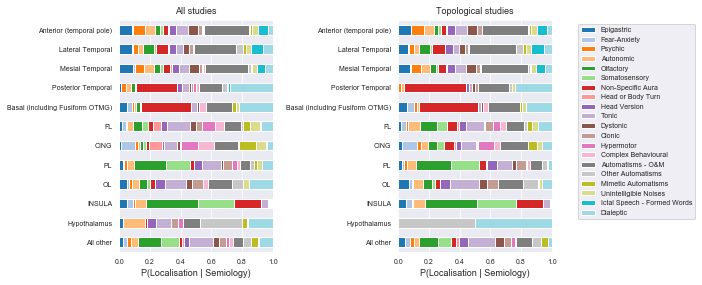

In [650]:
sns.set_style('darkgrid')

y_sums_1 = [int(n) for n in results['full']['counts'].sum(0)]
y_sums_2 = [int(n) for n in results['topology']['counts'].sum(0)]

combine_labels_1 = [label+f' (n={n})' for n, label in zip(y_sums_1, labels.clean_localisations(results['full']['counts'].columns))]
n_labels_1 = [f'n={n}' for n in y_sums_1]
n_labels_2 = [f'n={n}' for n in y_sums_2]

color_palette =  sns.color_palette("tab20", as_cmap=True)
fig, axs = plt.subplots(1, 2, sharex=True, sharey=False,)

plotter.plot_stacked_hbar(results['full']['proportion'].T, ax=axs[0],
                                      ax_title='All studies', axis=axis, color_palette=color_palette)
plotter.plot_stacked_hbar(results['topology']['proportion'].T, ax=axs[1],
                                      ax_title='Topological studies', axis=axis, color_palette=color_palette)

axs[0].get_legend().remove()
axs[1].legend(bbox_to_anchor=(1.15,1), loc="upper left", labels=labels.clean_semiologies(results['full']['proportion'].index))

# axs[0].set_yticklabels(combine_labels_1[::-1])
# axs[1].set_yticklabels(n_labels_2[::-1])

plt.tight_layout()
# plt.savefig(f'scripts/figures/working_figures/fig-2/bar/raw_temporal_breakdown.eps', dpi=300, pad_inches=0.5)

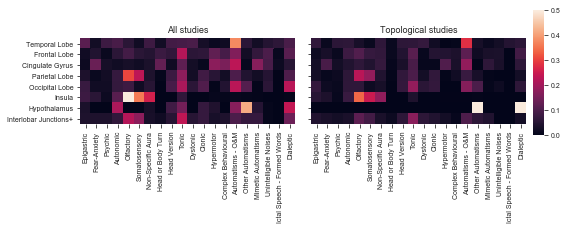

In [662]:
sns.set_style('ticks')
fig, axs = plt.subplots(1, 2, figsize=(7.5, 3), sharey=True, sharex=True)
cbar_ax = fig.add_axes([0.99, .38, .02, 0.576])
cbar_ax.patch.set_edgecolor('black')  
cbar_ax.patch.set_linewidth('1')  

heatmap_kwargs = {
    'square': True,
#      'xticklabels': x_labels
#     'vmin': 0.0,
#     'vmax': 1.0,
}

sns.heatmap(results['full']['proportion'].T, ax=axs[0], cbar=False, **heatmap_kwargs)
sns.heatmap(results['topology']['proportion'].T, ax=axs[1], cbar=True, cbar_ax = cbar_ax, **heatmap_kwargs)

axs[0].set_yticklabels(labels.clean_localisations(results['topology']['proportion'].columns), rotation=0)
axs[0].set_xticklabels(labels.clean_semiologies(results['topology']['proportion'].index))
axs[0].set_title('All studies')
axs[1].set_title('Topological studies')

# fig.colorbar(im, orientation="horizontal", pad=0.2)

plt.tight_layout()
plt.savefig(f'scripts/figures/working_figures/fig-2/heatmap/raw_top_level.eps', dpi=300, pad_inches=0.5)

# 2b - Region-specific subplots

- Q - use full, SS or topology?
- ***NOT RIGHT - NEEDS TO BE REWRTTTEN WITH NEW NORMALISATION

In [663]:
def get_specific_df(query_results, columns_of_interest):
    counts_matrix = []
    for semiology, value in query_results.items():
        query_inspection = value['query_inspection']
        semiology_counts = query_inspection[columns_of_interest].sum().values
        counts_matrix.append(semiology_counts)
    counts_df = pd.DataFrame(counts_matrix, index=query_results.keys(), columns=columns_of_interest)
    return counts_df

In [34]:
axis = 'zone'
normalised_or_not = 'normalised'

In [35]:
#Cingulate
cing_processed_dfs = {}
columns_of_interest = ['CING', 'Ant Cing (frontal, genu)', 'Post Cing', ]
for query_result_name, query_result in query_results[normalised_or_not].items():
    counts_df = get_specific_df(query_result, columns_of_interest)
    counts_df['Cingulate - (anterior + posterior)'] = counts_df['CING'] - (counts_df['Post Cing'] + counts_df['Ant Cing (frontal, genu)'])
    counts_df = interogate_queries.merge_all_other_semiologies(counts_df, sorted_semiologies[-20:])
    proportion_df = interogate_queries.calculate_proportions(counts_df, axis)
    confint_dfs = interogate_queries.calculate_confint(counts_df, axis = axis, method = 'binomial', alpha=0.05)
    cing_processed_dfs[query_result_name] = {
        'counts': counts_df,
        'proportion': proportion_df,
        'confints': confint_dfs
    }

/Users/karan/anaconda3/envs/semiology-vis/lib/python3.9/site-packages/statsmodels/stats/proportion.py:137: RuntimeWarning: invalid value encountered in sqrt
  dist = crit * np.sqrt(q_ * (1. - q_) / nobs + crit2 / (4. * nobs**2))


In [36]:
# SMA
sma_processed_dfs = {}
columns_of_interest = ['SSMA', 'SMA (pre-central gyrus; posterior SFG, MFG)', 'FL']
for query_result_name, query_result in query_results[normalised_or_not].items():
    counts_df = get_specific_df(query_result, columns_of_interest)
    counts_df['SMA'] = counts_df['SSMA'] + counts_df['SMA (pre-central gyrus; posterior SFG, MFG)']
    counts_df['FL-SMA'] = counts_df['FL'] - counts_df['SMA']
    counts_df = counts_df.drop(['SMA (pre-central gyrus; posterior SFG, MFG)', 'SSMA'], 1)
    counts_df = interogate_queries.merge_all_other_semiologies(counts_df, sorted_semiologies[-20:])
    proportion_df = interogate_queries.calculate_proportions(counts_df, axis)
    confint_dfs = interogate_queries.calculate_confint(counts_df, axis = axis, method = 'binomial', alpha=0.05)
    sma_processed_dfs[query_result_name] = {
        'counts': counts_df,
        'proportion': proportion_df,
        'confints': confint_dfs
    }

In [37]:
# PL
pl_processed_dfs = {}
columns_of_interest = ['PL',
                       'Primary Sensory Cortex (post-central gyrus)',
                       'medial anterior parietal',
                       'Sup. pariet. lobule',
                       'Inferior Parietal Lobule',]
for query_result_name, query_result in query_results[normalised_or_not].items():
    counts_df = get_specific_df(query_result, columns_of_interest)
    counts_df = interogate_queries.merge_all_other_semiologies(counts_df, sorted_semiologies[-20:])
    proportion_df = interogate_queries.calculate_proportions(counts_df, axis)
    confint_dfs = interogate_queries.calculate_confint(counts_df, axis = axis, method = 'binomial', alpha=0.05)
    pl_processed_dfs[query_result_name] = {
        'counts': counts_df,
        'proportion': proportion_df,
        'confints': confint_dfs
    }

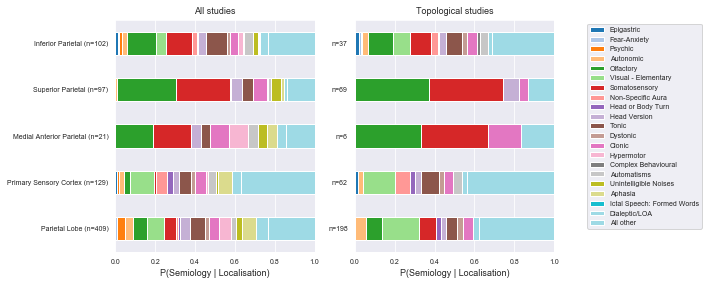

In [39]:
sns.set_style('darkgrid')
fig, axs = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(20, 2.5))

#Choose from {cing_processed_dfs, pl_processed_dfs, sma_processed_dfs}
processed_dfs = copy.deepcopy(pl_processed_dfs)

y_labels = labels.clean_localisations(processed_dfs['full']['counts'].columns)
y_sums_1 = [int(n) for n in processed_dfs['full']['counts'].sum()]
y_sums_2 = [int(n) for n in processed_dfs['topology']['counts'].sum()]

combine_labels_1 = [label+f' (n={n})' for n, label in zip(y_sums_1, y_labels)]
n_labels_1 = [f'n={n}' for n in y_sums_1]
n_labels_2 = [f'n={n}' for n in y_sums_2]

plot_stacked_hbar(processed_dfs['full']['proportion'], ax=axs[0], ax_title='All studies', axis=axis, color_palette=color_palette)
plot_stacked_hbar(processed_dfs['topology']['proportion'], ax=axs[1], ax_title='Topological studies', axis=axis, color_palette=color_palette)

axs[0].get_legend().remove()
axs[0].set_yticklabels(combine_labels_1)
axs[1].set_yticklabels(n_labels_2)
axs[1].legend(bbox_to_anchor=(1.15,1), loc="upper left", labels=labels.clean_semiologies(processed_dfs['topology']['proportion'].index))

plt.tight_layout()
# plt.savefig('/Users/karan/Downloads/PL.png', dpi=300, pad_inches=0.5)

---
# Figure 3: Odds ratio
---

Odds of semiology 1 localising to lobe A, divided by odds of NotSemiology A localising to lobe A. NotSemiology can be obtained by removing the result of QUERY_SEMIOLOGY from the original_df.
This gives Relative localising values. Interpret as intrinsic values of a specific semiology vs other semiologies. Narrow clinical history question.

In [691]:
def odds_ratio_df(counts, total_row, log_odds=False):
    melted = counts.reset_index().melt(id_vars='index')
    melted = melted.rename(columns={'index': 'semiology', 'variable': 'localisation', 'value': 'a'})
    melted['localisation_total'] = np.zeros(len(melted))
    for localisation, total in total_row.to_dict().items():
        mask = melted['localisation'] == localisation
        melted.loc[mask, 'localisation_total'] = total
        
    melted['c'] = melted['localisation_total'] - melted['a']
    
    melted['semiology_total'] = np.zeros(len(melted))
    for semiology, total in counts.sum(1).to_dict().items():
        mask = melted['semiology'] == semiology
        melted.loc[mask, 'semiology_total'] = total
        
    melted['b'] = melted['semiology_total']-melted['a']
    
    melted['d'] = np.repeat(total_row.sum(), len(melted)) - (melted['a'] + melted['b'] + melted['c'])
    
    melted['OR'] = np.nan
    melted['OR_lower_ci'] = np.nan
    melted['OR_upper_ci'] = np.nan
    
    for i in melted.index:
        contingency_table = Table2x2(
        [[melted.loc[i, 'a'], melted.loc[i, 'b']],
         [melted.loc[i, 'c'], melted.loc[i, 'd']]] )
        
        if not log_odds:
            melted.loc[i, 'OR'] = contingency_table.oddsratio
            melted.loc[i, 'OR_lower_ci'] = contingency_table.oddsratio_confint(alpha = 0.05)[0]
            melted.loc[i, 'OR_upper_ci'] = contingency_table.oddsratio_confint(alpha = 0.05)[1]
        else:
            melted.loc[i, 'OR'] = contingency_table.log_oddsratio
            melted.loc[i, 'OR_lower_ci'] = contingency_table.log_riskratio_confint(alpha = 0.05)[0]
            melted.loc[i, 'OR_upper_ci'] = contingency_table.log_riskratio_confint(alpha = 0.05)[1]

    or_pivot = melted.pivot_table(index=['semiology',], columns='localisation', values='OR')
    or_l_pivot = melted.pivot_table(index=['semiology',], columns='localisation', values='OR_lower_ci')
    or_u_pivot = melted.pivot_table(index=['semiology',], columns='localisation', values='OR_upper_ci')
    
    or_dfs = {
        'counts': counts,
        'or': or_pivot,
        'confints': (or_l_pivot, or_u_pivot)
    }
    
    return or_dfs

In [724]:
order = ['Anterior (temporal pole)',
             'Lateral Temporal',
             'Mesial Temporal',
             'Posterior Temporal',
             'Basal (including Fusiform OTMG)',
             'Hypothalamus',
             'PL',
             'CING',
             'OL',
             'FL',
             'INSULA',
             'All other',
             ]

In [756]:
results = {}
for study_type, query_result in query_results.items():
    result = interogate_queries.summarise_query(
        query_result,
        axis = 'semiology',
        region_names = region_names,
        normalise = True,
        merge_temporal = False,
        semiologies_of_interest = sorted_semiologies[-12:],
        drop_other_semiology = True,
        merge_other_regions = True,
        drop_other_regions = False,
        confint_method = 'bootstrap',
        bootstrapping_samples = 10000)
    
    results[study_type] = result

In [757]:
total_row = all_dfs['full'][region_names['low_level_temporal_of_interest']+region_names['of_interest_minus_tl']].sum()
total_row['All other'] = all_dfs['full'][region_names['top_level_all_other']].sum().sum()
odds_dfs = {}
odds_dfs['full'] = odds_ratio_df(results['full']['counts'], total_row, log_odds = False)
odds_dfs['spontaneous'] = odds_ratio_df(results['spontaneous']['counts'], total_row, log_odds = False)

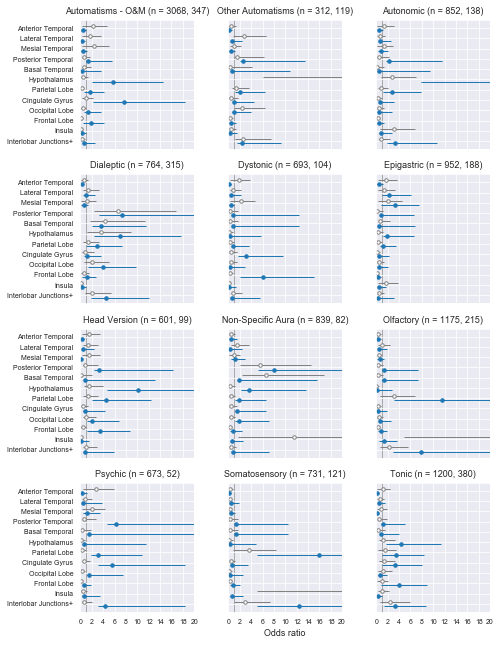

In [758]:
sns.set_style('darkgrid')
plotter.plot_proportion_ci_forest_plot(
    proportion_df_1 = odds_dfs['full']['or'],
    confint_df_1 = [df[order] for df in odds_dfs['full']['confints']],
    counts_df_1 = results['full']['counts'][order],
    colors = colors,
    legend_labels = legend_labels,
    proportion_df_2 = odds_dfs['spontaneous']['or'][order],
    confint_df_2 = [df[order] for df in odds_dfs['spontaneous']['confints']],
    counts_df_2 = results['spontaneous']['counts'][order],
    y_labels = labels.clean_localisations(odds_dfs['full']['or'][order].columns),
    overlapping=False,
    ax_titles = labels.clean_semiologies(odds_dfs['full']['or'][order].index),
    xlim = [-0.05,20],
    xticks = np.arange(0, 21, 2),
    vline = 1.0,
    xlabel = 'Odds ratio',
    figsize = (7, 9),
    plotter_settings = plotter_settings,
)

plt.savefig(f'scripts/figures/working_figures/fig-3/normalised_temporal_breakdown.eps', dpi=300, pad_inches=0.5)

## TL as a single category

In [759]:
results = {}
for study_type, query_result in query_results.items():
    result = interogate_queries.summarise_query(
        query_result,
        axis = 'semiology',
        region_names = region_names,
        normalise = True,
        merge_temporal = True,
        semiologies_of_interest = sorted_semiologies[-12:],
        drop_other_semiology = True,
        merge_other_regions = True,
        drop_other_regions = False,
        confint_method = 'bootstrap',
        bootstrapping_samples = 10000)
    
    results[study_type] = result

/Volumes/Encrypted/Semiology-Visualisation-Tool/scripts/figures/interogate_queries.py:148: RuntimeWarning: invalid value encountered in true_divide
  top_level_ratio = (localising.values.T/all_regions.sum(1).values)[0]


In [760]:
total_row = all_dfs['full'][region_names['of_interest']].sum()
total_row['All other'] = all_dfs['full'][region_names['top_level_all_other']].sum().sum()
odds_dfs = {}
odds_dfs['full'] = odds_ratio_df(results['full']['counts'], total_row, log_odds = False)
odds_dfs['spontaneous'] = odds_ratio_df(results['spontaneous']['counts'], total_row, log_odds = False)

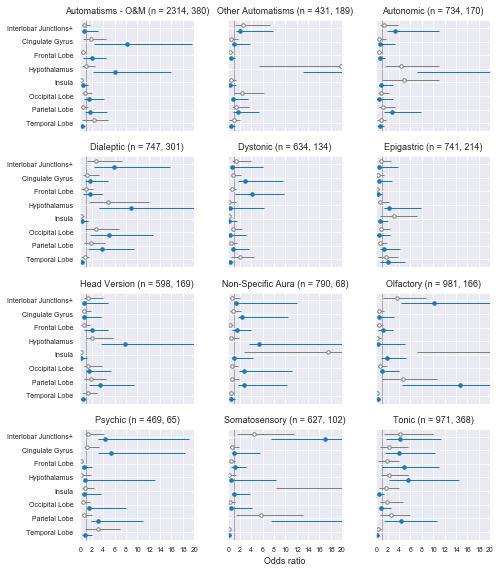

In [761]:
sns.set_style('darkgrid')
plotter.plot_proportion_ci_forest_plot(
    proportion_df_1 = odds_dfs['full']['or'],
    confint_df_1 = [df for df in odds_dfs['full']['confints']],
    counts_df_1 = results['full']['counts'],
    colors = colors,
    legend_labels = legend_labels,
    proportion_df_2 = odds_dfs['spontaneous']['or'],
    confint_df_2 = [df for df in odds_dfs['spontaneous']['confints']],
    counts_df_2 = results['spontaneous']['counts'],
    y_labels = labels.clean_localisations(odds_dfs['full']['or'].columns),
    overlapping=False,
    ax_titles = labels.clean_semiologies(odds_dfs['full']['or'].index),
    xlim = [-0.05,20],
    xticks = np.arange(0, 21, 2),
    vline = 1.0,
    xlabel = 'Odds ratio',
#     figsize = (7, 9),
    plotter_settings = plotter_settings,
)

plt.savefig(f'scripts/figures/working_figures/fig-3/normalised_top_level.eps', dpi=300, pad_inches=0.5)

In [726]:
results['full']['counts']

,TL,FL,CING,PL,OL,INSULA,Hypothalamus,All other
Epigastric,620.0,29.0,5.0,12.0,13.0,84.0,5.0,6.0
Psychic,423.0,17.0,9.0,8.0,4.0,17.0,0.0,6.0
Autonomic,502.0,75.0,7.0,23.0,12.0,121.0,30.0,10.0
Olfactory,296.0,118.0,9.0,99.0,14.0,528.0,0.0,34.0
Somatosensory,116.0,73.0,7.0,75.0,4.0,381.0,0.0,27.0
Non-Specific Aura,432.0,62.0,11.0,13.0,9.0,276.0,4.0,5.0
Head Version,467.0,84.0,6.0,25.0,16.0,1.0,12.0,8.0
Tonic,488.0,293.0,37.0,57.0,36.0,67.0,21.0,36.0
Dystonic,516.0,77.0,8.0,8.0,10.0,1.0,0.0,8.0
Automatisms - Oral & Manual,2015.0,215.0,70.0,32.0,39.0,11.0,24.0,15.0


## Log odds
- gets weird - confidence limits don't include point estimate sometimes - need to investigate

In [705]:
total_row = all_dfs['full'][regions_of_interest].sum()
total_row['All other'] = all_dfs['full'][region_names['top_level_all_other']].sum().sum()
log_odds_dfs = {}
log_odds_dfs['full'] = odds_ratio_df(results['full']['counts'], total_row, log_odds = True)
log_odds_dfs['spontaneous'] = odds_ratio_df(results['spontaneous']['counts'], total_row, log_odds = True)

(<Figure size 504x648 with 12 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x147ddaaf0>,
       dtype=object))

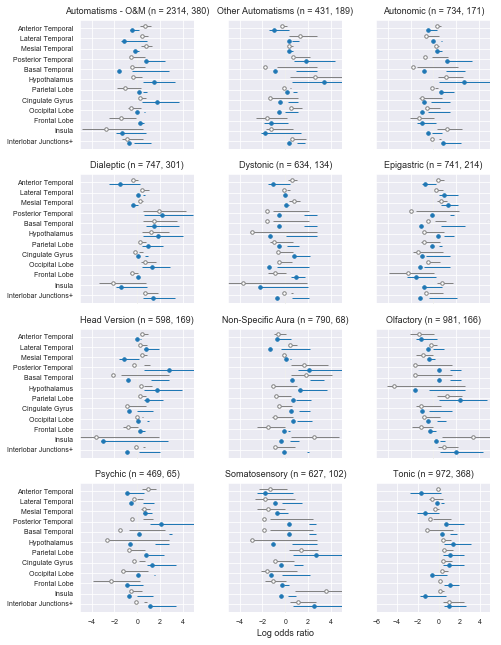

In [703]:
sns.set_style('darkgrid')
plotter.plot_proportion_ci_forest_plot(
    proportion_df_1 = log_odds_dfs['full']['or'][order],
    confint_df_1 = [df[order] for df in log_odds_dfs['full']['confints']],
    counts_df_1 = results['full']['counts'][order],
    colors = colors,
    legend_labels = legend_labels,
    proportion_df_2 = log_odds_dfs['spontaneous']['or'][order],
    confint_df_2 = [df[order] for df in log_odds_dfs['spontaneous']['confints']],
    counts_df_2 = results['spontaneous']['counts'][order],
    y_labels = labels.clean_localisations(log_odds_dfs['full']['or'][order].columns),
    overlapping=False,
    ax_titles = labels.clean_semiologies(log_odds_dfs['full']['or'][order].index),
    xlim = [-5,5],
    xticks = np.arange(-6, 6, 2),
    vline = 0,
    xlabel = 'Log odds ratio',
    figsize = (7, 9),
    plotter_settings = plotter_settings,
)

# plt.savefig('/Users/karan/Downloads/or_log_v1.png', dpi=300, pad_inches=0.5, bbox_inches = "tight")

In [170]:
np.log(odds_dfs['full']['or'][order])

localisation,Anterior (temporal pole),Lateral Temporal,Mesial Temporal,Posterior Temporal,Basal (including Fusiform OTMG),Hypothalamus,PL,CING,OL,FL,INSULA,All other
semiology,,,,,,,,,,,,
Automatisms Combination - Manual LowerLimb Oral,0.587881,0.532775,0.714003,-0.630543,-0.543647,-0.767051,-1.451725,-0.237882,-0.817000,-1.040490,-4.540588,-1.297179
Autonomous-Vegetative,0.083328,-0.650352,-0.000863,-0.998120,-1.559593,0.924738,-0.709829,-1.325805,-0.620691,-0.490350,0.953377,-0.362705
Dialeptic/LOA,-0.451875,-0.388612,0.271695,1.390914,0.576197,0.968796,-0.126367,-0.162379,-0.374832,0.405587,-3.093509,0.530584
Dystonic,0.376716,-0.158235,0.620148,-1.037617,-1.304587,-3.162354,-1.140737,-0.617592,-0.556502,-0.238027,-4.528223,-0.340481
Epigastric,0.241778,0.323356,0.625691,-1.446474,-0.235351,-1.236701,-1.634344,-1.702785,-0.887837,-1.979065,0.335885,-1.055262
Non-Specific Aura,-1.129495,-0.246686,-0.250315,0.946879,1.181929,-1.449742,-0.865949,-0.849482,-1.216641,-0.713726,2.380666,-1.227450
Olfactory,-1.411058,-0.449914,-1.127317,-1.401463,-1.562466,-3.941957,0.739674,-1.626389,-1.437337,-0.752344,3.496261,0.483480
Somatosensory,-1.455869,-1.777477,-1.678054,-2.051160,-1.799259,-3.472143,1.064181,-1.416906,-2.186254,-0.709584,3.414784,0.692001
Tonic,-0.016242,-0.710603,-0.486907,-0.829741,-0.964283,0.039332,0.439611,0.055200,0.081069,0.773789,-0.231200,0.670957


In [137]:
odds_dfs['full']['counts'].loc['Olfactory', 'INSULA']

507.3333333333333

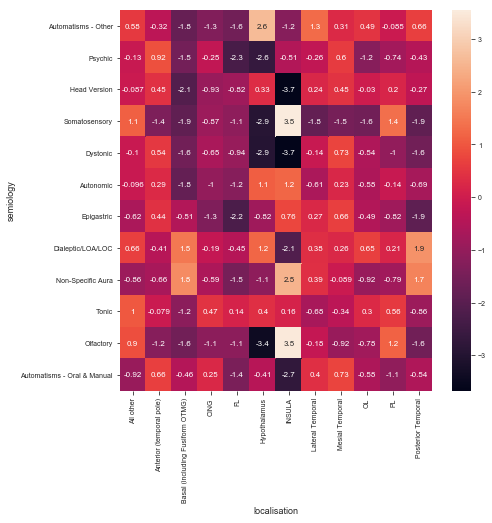

In [707]:
# Log odds
sns.set_style('ticks')
fig, ax = plt.subplots(1, figsize=(7, 7))
sns.heatmap(log_odds_dfs['full']['or'].loc[semiologies_of_interest], cbar=True, annot=True)

# # fig.colorbar(im, orientation="horizontal", pad=0.2)

plt.tight_layout()
# plt.savefig('/Users/karan/Downloads/heatmap4.png', dpi=300, pad_inches=0.5, bbox_inches = "tight")

# NMI/Correlation

In [709]:
import dython

In [765]:
results = {}
for study_type, query_result in query_results.items():
    result = interogate_queries.summarise_query(
        query_result,
        axis = 'zone',
        region_names = region_names,
        normalise = True,
        merge_temporal = False,
        semiologies_of_interest = sorted_semiologies[-20:],
        drop_other_semiology = True,
        merge_other_regions = True,
        drop_other_regions = False,
        confint_method = 'bootstrap',
        bootstrapping_samples = 10000)
    
    results[study_type] = result

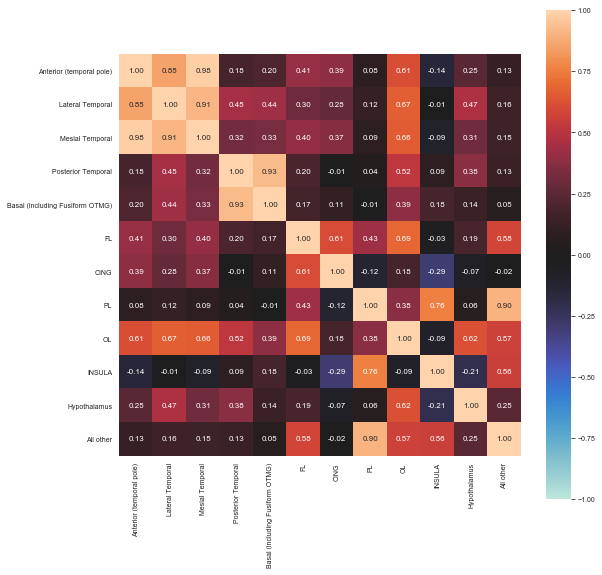

<Figure size 432x288 with 0 Axes>

In [766]:
dython.nominal.associations(results['full']['counts'], theil_u=True, figsize=(9, 9))
plt.tight_layout()

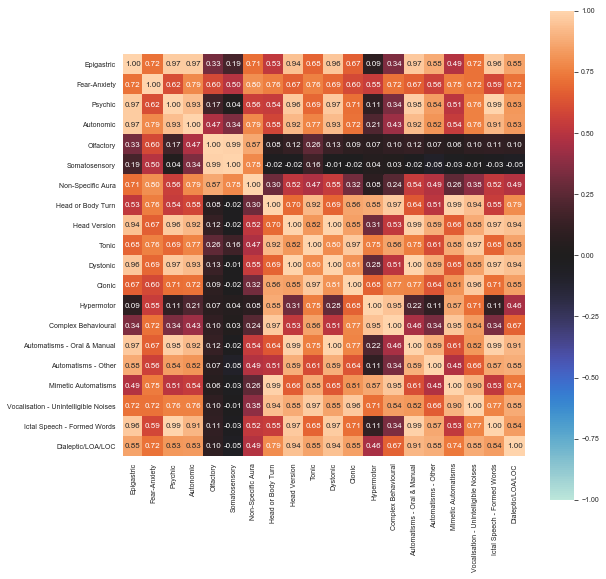

<Figure size 432x288 with 0 Axes>

In [767]:
dython.nominal.associations(results['full']['counts'].T, theil_u=True, figsize=(9, 9))
plt.tight_layout()

# Compare normalisation methods

In [510]:
axis='semiology'
regions_of_interest = region_names['of_interest_minus_tl']+region_names['low_level_temporal_of_interest']+['Localising']
# regions_of_interest = region_names['of_interest']
semiologies_of_interest = sorted_semiologies[-12:]
processed_dfs = {}
for normalised_type, sub_query_results in query_results.items():
    processed_dfs[normalised_type] = {}
    for study_type, query_result in sub_query_results.items():
        processed_dfs[normalised_type][study_type] = interogate_queries.summarise_query(
            query_result,
            axis = 'semiology',
            region_names = region_names,
            confint_method = 'binomial',
            bootstrapping_samples=1000,
            merge_temporal = False,
            other_regions_included = True,
            semiologies_of_interest = semiologies_of_interest,
            regions_of_interest = regions_of_interest,
            drop_other_semiology = True)

TypeError: summarise_query() got an unexpected keyword argument 'other_regions_included'

In [527]:
axis='semiology'
regions_of_interest = region_names['of_interest_minus_tl']+region_names['low_level_temporal_of_interest']

results, localising = interogate_queries.summarise_query(
    query_results['raw']['full'],
    axis = 'semiology',
    region_names = region_names,
    normalise = True,
    merge_temporal = False,
    semiologies_of_interest = sorted_semiologies[-12:],
    drop_other_semiology = True,
    regions_of_interest = regions_of_interest,
    drop_other_regions = False,
    confint_method = 'binomial',
    bootstrapping_samples=100)

In [533]:
pd.concat([results['counts'], results['counts'].sum(1), localising], 1)

,Anterior (temporal pole),Lateral Temporal,Mesial Temporal,Posterior Temporal,Basal (including Fusiform OTMG),FL,CING,PL,OL,INSULA,Hypothalamus,All other,0,Localising
Epigastric,217.938354,39.422296,332.486157,0.743817,2.975268,27.763566,4.786822,11.488372,12.445736,80.418605,4.786822,5.744186,741.0,741.0
Psychic,186.861844,15.404381,204.945248,2.009267,0.669756,16.473140,8.721074,7.752066,3.876033,16.473140,0.000000,5.814050,469.0,469.0
Autonomic,194.225069,17.282739,257.595113,2.468963,0.822988,70.576923,6.587179,21.643590,11.292308,113.864103,28.230769,9.410256,734.0,734.0
Olfactory,75.863578,34.741265,151.018151,1.418011,1.418011,105.426230,8.040984,88.450820,12.508197,471.737705,0.000000,30.377049,981.0,981.0
Somatosensory,42.206014,4.545263,58.439096,0.649323,0.649323,67.014641,6.426061,68.850659,3.672035,349.761347,0.000000,24.786237,627.0,627.0
Non-Specific Aura,100.724428,46.699507,226.172124,21.976239,24.723269,60.320197,10.701970,12.647783,8.756158,268.522167,3.891626,4.864532,790.0,790.0
Head Version,176.845390,31.148904,240.148001,3.014410,0.000000,81.150242,5.796446,24.151858,15.457189,0.966074,11.592892,7.728595,598.0,598.0
Tonic,197.214515,21.756761,234.411559,2.807324,2.105493,275.165217,34.747826,53.530435,33.808696,62.921739,19.721739,33.808696,972.0,972.0
Dystonic,199.943848,23.311839,295.881031,0.896609,0.896609,77.735669,8.076433,8.076433,10.095541,1.009554,0.000000,8.076433,634.0,634.0
Automatisms - Oral & Manual,743.752912,131.676099,1030.980447,9.405436,10.128931,205.497728,66.906237,30.585708,37.276332,10.513837,22.939281,14.337051,2314.0,2314.0


----
## Reference
----

In [290]:
query_results = {}
query_results['raw'] = {}
for key, df in all_dfs['raw'].items():
    query_results['raw'][key] = query_semiology_wrapper(df, semiology_list, semiology_dict_path)

In [362]:
reload(Sankey_Functions)
top_level_normalised_df = Sankey_Functions.normalise_top_level_localisation_cols_OTHER(copy.deepcopy(original_df))[0]
all_dfs['top_level_normalised'] = {
    'full': top_level_normalised_df,
    'spontaneous': top_level_normalised_df[top_level_normalised_df['Spontaneous Semiology (SS)'] == 'y'],
    'topology':  top_level_normalised_df[top_level_normalised_df['Spontaneous Semiology (SS)'] != 'y'],
}

In [363]:
query_results['top_level_normalised'] = {}
for key, df in all_dfs['top_level_normalised'].items():
    query_results['top_level_normalised'][key] = query_semiology_wrapper(df, semiology_list, semiology_dict_path)

In [364]:
reload(Sankey_Functions)
temporal_normalised_df = Sankey_Functions.normalise_localisation_cols_OTHER_SplitTL(copy.deepcopy(original_df))[0]
all_dfs['temporal_normalised'] = {
    'full': temporal_normalised_df,
    'spontaneous': temporal_normalised_df[temporal_normalised_df['Spontaneous Semiology (SS)'] == 'y'],
    'topology':  temporal_normalised_df[temporal_normalised_df['Spontaneous Semiology (SS)'] != 'y'],
}

In [365]:
query_results['temporal_normalised'] = {}
for key, df in all_dfs['temporal_normalised'].items():
    query_results['temporal_normalised'][key] = query_semiology_wrapper(df, semiology_list, semiology_dict_path)

In [440]:
with open('scripts/figures/query_results_pickle.pkl', 'wb') as f:
    pickle.dump(query_results, f)
    
with open('scripts/figures/all_dfs_pickle.pkl', 'wb') as f:
    pickle.dump(all_dfs, f)

In [549]:
axis='semiology'
regions_of_interest = region_names['of_interest_minus_tl']+region_names['low_level_temporal_of_interest']
# regions_of_interest = region_names['of_interest']
semiologies_of_interest = sorted_semiologies[-12:]
processed_dfs = {}
for normalised_type, sub_query_results in query_results.items():
    processed_dfs[normalised_type] = {}
    for study_type, query_result in sub_query_results.items():
        processed_dfs[normalised_type][study_type] = interogate_queries.summarise_query(
            query_result,
            axis = 'semiology',
            region_names = region_names,
            confint_method = 'binomial',
            bootstrapping_samples=1000,
            merge_temporal = False,
            other_regions_included = True,
            semiologies_of_interest = semiologies_of_interest,
            regions_of_interest = regions_of_interest,
            drop_other_semiology = True)

TypeError: summarise_query() got an unexpected keyword argument 'other_regions_included'

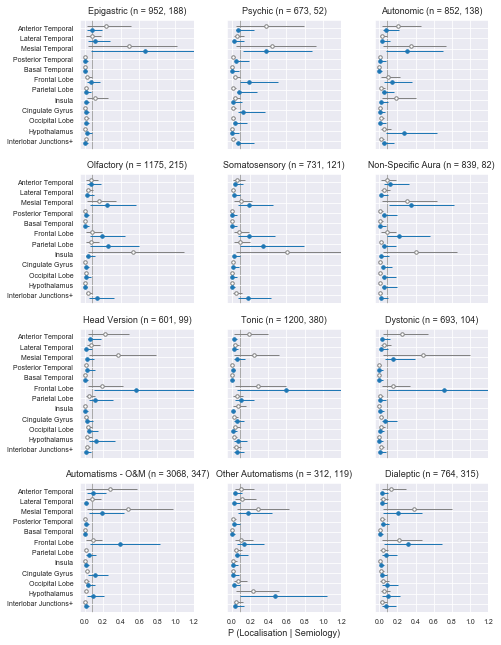

In [303]:
sns.set_style('darkgrid')
normalisation = 'temporal_normalised'
fig, axs = plotter.plot_proportion_ci_forest_plot(
                               proportion_df_1 = processed_dfs[normalisation]['full']['proportion'],
                               confint_df_1 = processed_dfs[normalisation]['full']['confints'],
                               counts_df_1 = processed_dfs['raw']['full']['counts'],
                               colors = colors,
                               legend_labels = legend_labels,
                               proportion_df_2 = processed_dfs[normalisation]['spontaneous']['proportion'],
                               confint_df_2 = processed_dfs[normalisation]['spontaneous']['confints'],
                               counts_df_2 = processed_dfs['raw']['spontaneous']['counts'],
                               y_labels = labels.clean_localisations(processed_dfs[normalisation]['full']['proportion'].columns),
                               overlapping=False,
                               ax_titles = labels.clean_semiologies(processed_dfs[normalisation]['full']['proportion'].index),
                               plotter_settings = plotter_settings,
                               xlim = [-0.05,1.2],
                               xticks = np.arange(0, 1.3, 0.2),
                               figsize = (7, 9)
                              )

plt.savefig(F'scripts/figures/working_figures/fig-1/{normalisation}_not_bootstrapped.eps', dpi=300, pad_inches=0.5)

In [118]:
regions_of_interest = region_names['of_interest_minus_tl']+region_names['low_level_temporal_of_interest']
# regions_of_interest = region_names['of_interest']
semiologies_of_interest = sorted_semiologies[-20:]
axis = 'zone'

processed_dfs = {}
for normalised_or_not, sub_query_results in query_results.items():
    processed_dfs[normalised_or_not] = {}
    for study_type, query_result in sub_query_results.items():
        processed_dfs[normalised_or_not][study_type] = interogate_queries.summarise_query(query_result,
                                                                      axis = axis,
                                                                      region_names = region_names,
                                                                      confint_method = 'binomial',
                                                                      merge_temporal = False,
                                                                      other_regions_included = True,
                                                                      semiologies_of_interest = semiologies_of_interest,
                                                                      regions_of_interest = regions_of_interest,
                                                                      drop_other_semiology = False)

/Users/karan/anaconda3/envs/semiology-vis/lib/python3.9/site-packages/statsmodels/stats/proportion.py:90: RuntimeWarning: invalid value encountered in true_divide
  q_ = count * 1. / nobs
/Users/karan/anaconda3/envs/semiology-vis/lib/python3.9/site-packages/statsmodels/stats/proportion.py:135: RuntimeWarning: divide by zero encountered in double_scalars
  denom = 1 + crit2 / nobs
/Users/karan/anaconda3/envs/semiology-vis/lib/python3.9/site-packages/statsmodels/stats/proportion.py:136: RuntimeWarning: divide by zero encountered in double_scalars
  center = (q_ + crit2 / (2 * nobs)) / denom
/Users/karan/anaconda3/envs/semiology-vis/lib/python3.9/site-packages/statsmodels/stats/proportion.py:137: RuntimeWarning: divide by zero encountered in double_scalars
  dist = crit * np.sqrt(q_ * (1. - q_) / nobs + crit2 / (4. * nobs**2))


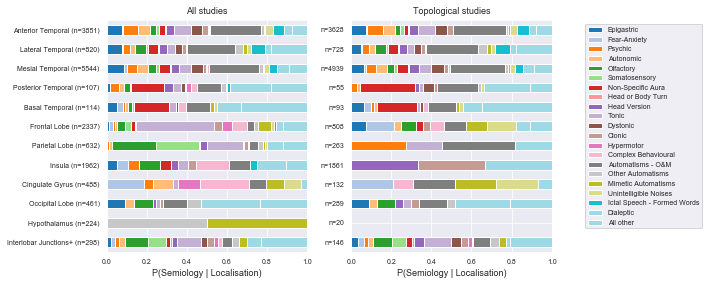

In [103]:
sns.set_style('darkgrid')
normalisation = 'temporal_normalised'

y_sums_1 = [int(n) for n in processed_dfs['raw']['full']['counts'].sum(0)]
y_sums_2 = [int(n) for n in processed_dfs['raw']['topology']['counts'].sum(0)]

combine_labels_1 = [label+f' (n={n})' for n, label in zip(y_sums_1, labels.clean_localisations(processed_dfs[normalisation]['full']['counts'].columns))]
n_labels_1 = [f'n={n}' for n in y_sums_1]
n_labels_2 = [f'n={n}' for n in y_sums_2]

color_palette =  sns.color_palette("tab20", as_cmap=True)
fig, axs = plt.subplots(1, 2, sharex=True, sharey=False,)

plotter.plot_stacked_hbar(processed_dfs[normalisation]['full']['proportion'], ax=axs[0],
                                      ax_title='All studies', axis=axis, color_palette=color_palette)
plotter.plot_stacked_hbar(processed_dfs[normalisation]['topology']['proportion'], ax=axs[1],
                                      ax_title='Topological studies', axis=axis, color_palette=color_palette)

axs[0].get_legend().remove()
axs[1].legend(bbox_to_anchor=(1.15,1), loc="upper left", labels=labels.clean_semiologies(processed_dfs[normalisation]['topology']['proportion'].index))

axs[0].set_yticklabels(combine_labels_1[::-1])
axs[1].set_yticklabels(n_labels_2[::-1])

plt.tight_layout()
plt.savefig(f'scripts/figures/working_figures/fig-2/bar/{normalisation}.eps', dpi=300, pad_inches=0.5)